In [1]:
import numpy as np
import pandas as pd
import datetime
from dateutil.rrule import rrule, MONTHLY
import matplotlib.pyplot as plt
from collections import Counter

In [1]:
AZ_reviews = pd.read_csv('AZ_review.csv')

In [2]:
print(AZ_reviews.columns)
AZ_reviews.describe()

Index(['Unnamed: 0', 'business_id', 'name', 'cool', 'date', 'funny',
       'review_id', 'stars', 'text', 'useful', 'user_id', 'categories',
       'attributes'],
      dtype='object')


,Unnamed: 0,cool,funny,stars,useful
count,1.877589e+06,1.877589e+06,1.877589e+06,1.877589e+06,1.877589e+06
mean,2.997879e+06,5.401640e-01,4.793834e-01,3.785140e+00,1.400640e+00
std,1.702537e+06,2.337093e+00,3.132605e+00,1.502391e+00,4.451211e+00
min,3.200000e+01,-1.000000e+00,0.000000e+00,1.000000e+00,-1.000000e+00
25%,1.492337e+06,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00
50%,3.059081e+06,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00
75%,4.456132e+06,0.000000e+00,0.000000e+00,5.000000e+00,2.000000e+00
max,5.995863e+06,5.050000e+02,9.910000e+02,5.000000e+00,1.234000e+03


In [3]:
AZ_reviews['business_id'].describe()

count                    1877589
unique                     56495
top       JmI9nslLD7KZqRr__Bg6NQ
freq                        2390
Name: business_id, dtype: object

In [4]:
top_biz = "JmI9nslLD7KZqRr__Bg6NQ"
top_reviews = AZ_reviews[AZ_reviews['business_id'] == "JmI9nslLD7KZqRr__Bg6NQ"]
top_reviews_sorted = top_reviews.sort_values(by =['date'])
top_reviews_sorted.head()['date']

345010    2006-06-25
345156    2006-08-07
344760    2006-08-13
344537    2006-08-30
344707    2006-09-03
Name: date, dtype: object

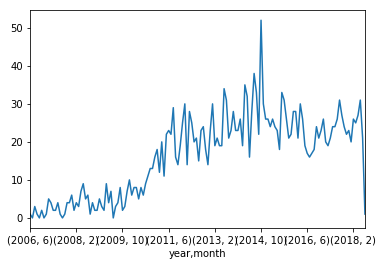

In [5]:
top_reviews_date = top_reviews.assign(datetime = pd.to_datetime(top_reviews_sorted['date'])).drop(labels=['date'], axis = 'columns')

top_reviews_reindexed = top_reviews_date.set_index('datetime').sort_index()
top_reviews_reindexed.index = top_reviews_reindexed.index.map(lambda t: t.replace(day=1))

min_date = pd.Timestamp(top_reviews_reindexed.index.min())
max_date = pd.Timestamp(top_reviews_reindexed.index.max())
dates = [dt for dt in rrule(MONTHLY, dtstart=min_date, until=max_date)]
date_frame = pd.DataFrame(dates, columns = ['datetime']).set_index('datetime')

all_dates = date_frame.join(top_reviews_reindexed)


groupbymonth = all_dates.groupby([all_dates.index.year.rename('year'), all_dates.index.month.rename('month')])

groupbymonth['business_id'].count().plot()
plt.show()



In [8]:
def hwr(x):
    return (x+np.abs(x))/2

def plot_by_month(df, business_id = None, label = None, plottype = 'count', compare_mean = False):
    reviews_sorted = df.sort_values(by =['date'])
    reviews_datetime = reviews_sorted.assign(datetime = pd.to_datetime(reviews_sorted['date'])).drop(labels=['date'], axis = 'columns')
    reviews_reindexed = reviews_datetime.set_index('datetime').sort_index()
    reviews_reindexed.index = reviews_reindexed.index.map(lambda t: t.replace(day=1))
    
    if business_id != None:
        reviews = reviews_reindexed[reviews_reindexed['business_id'] == business_id]
        title = reviews.loc[reviews.index[0]]['name']
    else:
        reviews = reviews_reindexed
        title = 'All Businesses'
    
    if label == None:
        label = 'business_id'
        title += ' - review ' + plottype
    else: 
        title += ' - ' + label + ' ' + plottype
    
    min_date = pd.Timestamp(reviews.index.min())
    max_date = pd.Timestamp(reviews.index.max())
    dates = [dt for dt in rrule(MONTHLY, dtstart=min_date, until=max_date)]
    date_frame = pd.DataFrame(dates, columns = ['datetime']).set_index('datetime')
    
    all_dates = date_frame.join(reviews)
    group_by_month = all_dates.groupby([all_dates.index.year.rename('year'), all_dates.index.month.rename('month')])
    
    if compare_mean == True:
        all_reviews = reviews_reindexed
        all_reviews_dates = date_frame.join(all_reviews)
        all_group_by_month  = all_reviews_dates.groupby([all_reviews_dates.index.year, all_reviews_dates.index.month])
        all_group_by_unique = all_group_by_month['business_id'].unique().apply(len)
        avg_group_by_month = all_group_by_month/all_group_by_unique

    if plottype == 'cumsum':
        np.cumsum(group_by_month[label].count()).plot(label = plottype)
    elif plottype == 'diff':
        diff = (np.diff(group_by_month[label].count()))
        plt.plot(date_frame.index[:-1], diff, label = plottype)
    elif plottype == 'pos_diff':
        diff = hwr(np.diff(group_by_month[label].count()))
        plt.plot(date_frame.index[:-1], diff, label = plottype)
    elif plottype == 'count':
        group_by_month[label].count().plot(label = plottype)    
        
    if compare_mean == True:
        if plottype == 'cumsum':
            np.cumsum(avg_group_by_month[label].count()).plot(label = plottype)
        elif plottype == 'diff':
            diff = (np.diff(avg_group_by_month[label].count()))
            plt.plot(date_frame.index[:-1], diff, label = plottype)
        elif plottype == 'pos_diff':
            diff = hwr(np.diff(avg_group_by_month[label].count()))
            plt.plot(date_frame.index[:-1], diff, label = plottype)
        elif plottype == 'count':
            avg_group_by_month[label].count().plot(label = plottype) 

        
        
    plt.title(title)
    plt.legend()
    plt.show()
    return group_by_month
    

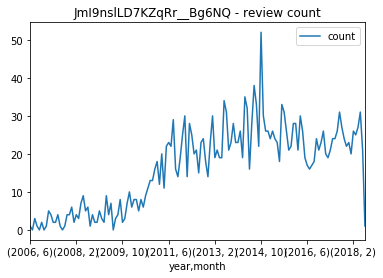

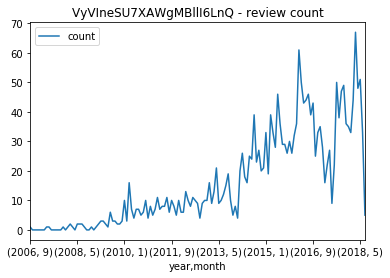

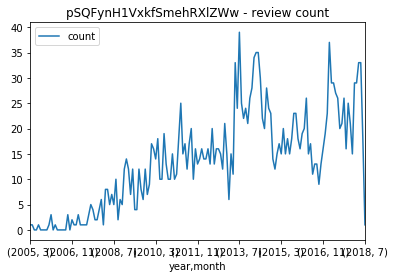

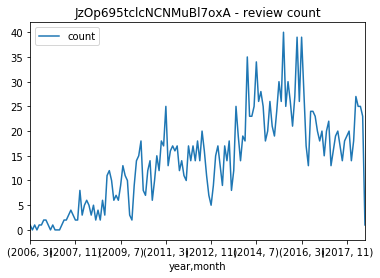

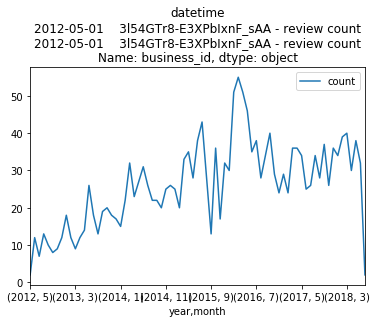

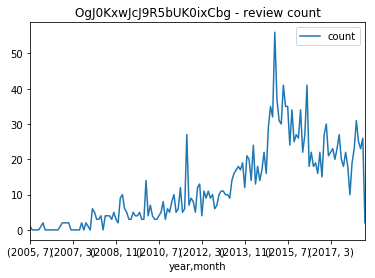

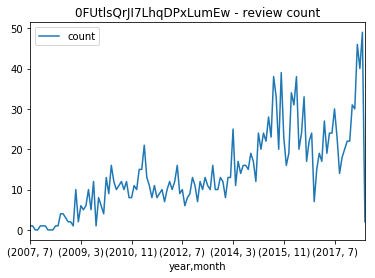

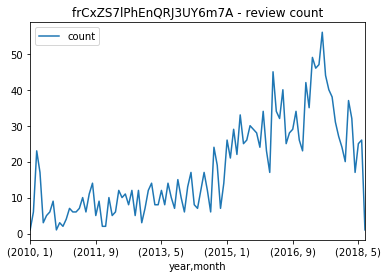

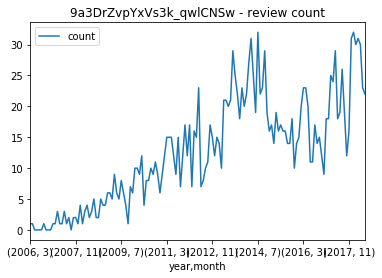

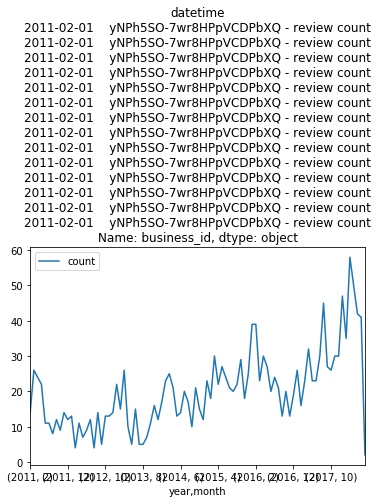

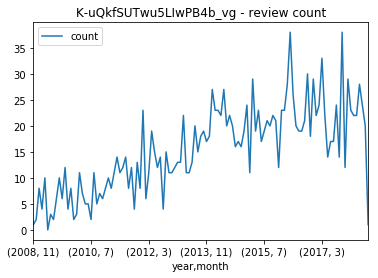

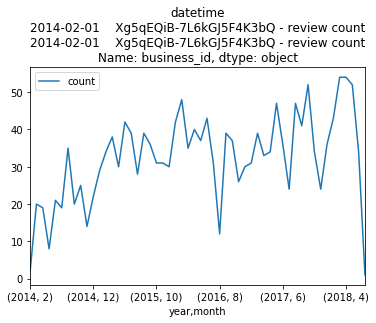

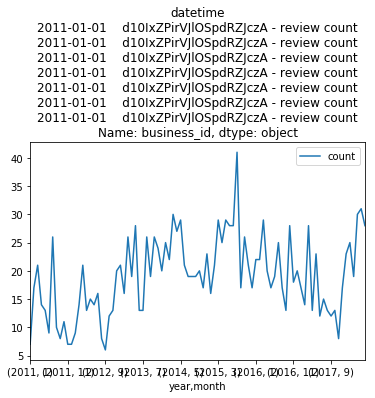

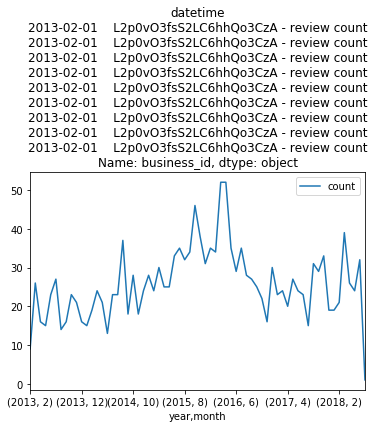

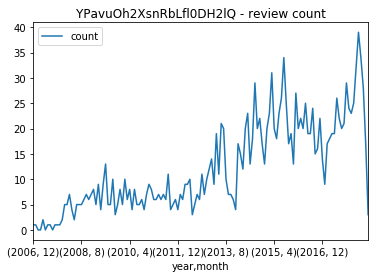

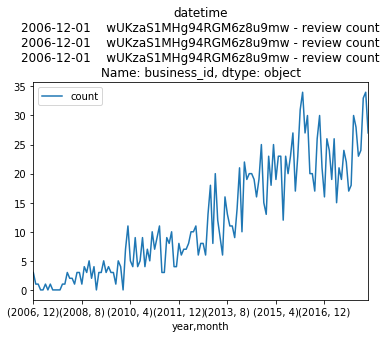

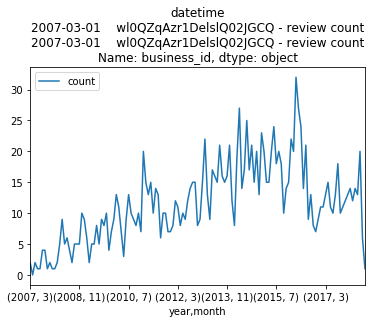

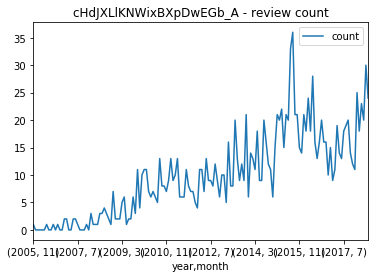

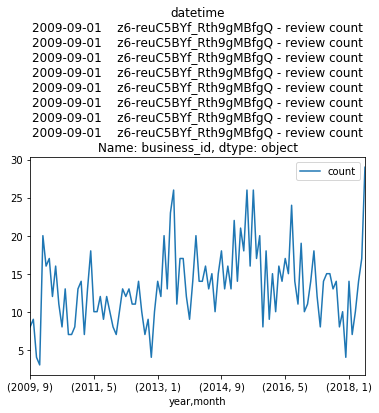

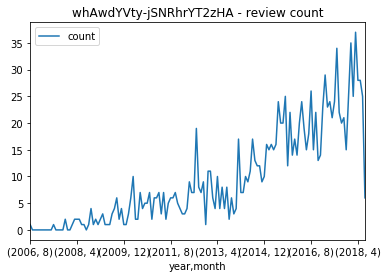

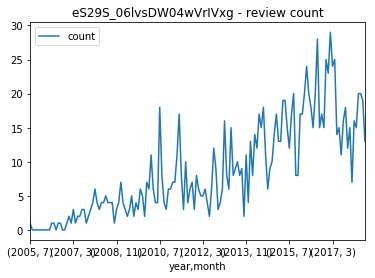

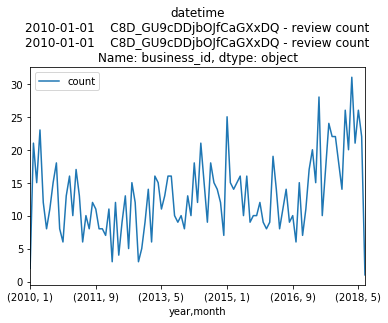

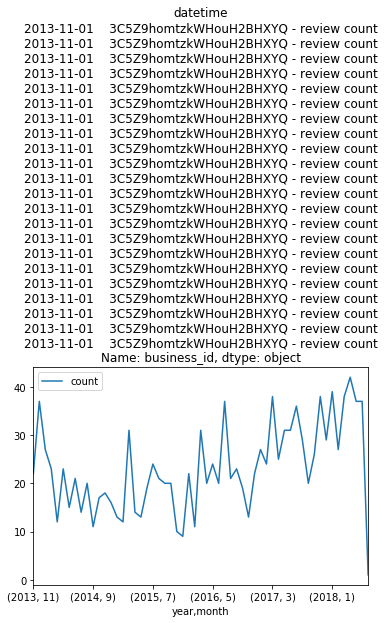

KeyboardInterrupt: 

In [7]:
business_groups = AZ_reviews.groupby('business_id')
sorted_groups = business_groups.size().sort_values(ascending=False)
for business_id, size in (sorted_groups.items()):
    if size>1000:
        plot_by_month(AZ_reviews, business_id = business_id, plottype = 'count', compare_mean=False)

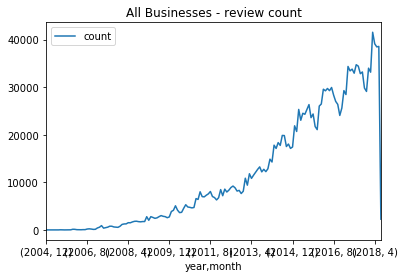

In [9]:
all_reviews = plot_by_month(AZ_reviews)


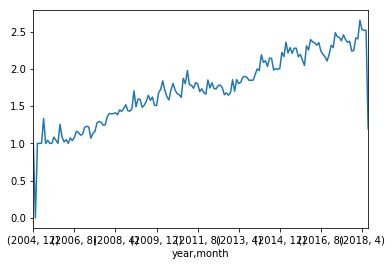

In [10]:
all_reviews_count = all_reviews['business_id'].count()
all_reviews_unique = all_reviews['business_id'].unique().apply(len)
(all_reviews_count/all_reviews_unique).plot()
plt.show()

In [26]:
biz_df, cats_df = biz_categories(AZ_reviews, 0.1)

/home/ci411/.conda/envs/py3.5/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  import sys


In [27]:
print(AZ_reviews['categories'])
print(biz_cats['categories'])
cats_df

0                              Insurance, Financial Services
1                              Insurance, Financial Services
2                              Insurance, Financial Services
3                              Insurance, Financial Services
4                              Insurance, Financial Services
5                              Insurance, Financial Services
6                              Insurance, Financial Services
7                              Insurance, Financial Services
8                                         Coffee & Tea, Food
9                                         Coffee & Tea, Food
10                                        Coffee & Tea, Food
11                                        Coffee & Tea, Food
12                                        Coffee & Tea, Food
13                                        Coffee & Tea, Food
14                                        Coffee & Tea, Food
15                                        Coffee & Tea, Food
16                      

,category,count
91,Bars,349865


In [25]:
def biz_categories(biz_df,min_percent):
    
    cat_list=('Afghan','African','Arabian','Argentine','Armenian','Australian','Austrian','Bangladeshi','Basque','Bavarian','Brasseries','British','Bulgarian','Burmese','Cambodian','Cantonese','Chilean','Colombian','Cuban','Czech','Czech/Slovakian','Dominican','Donairs','Eastern European','Egyptian','Ethiopian','Falafel','Filipino','Greek','Hainan','Haitian','Hakka','Halal','Hawaiian','Honduran','Hot Pot','Iberian','Indonesian','International','Irish','Irish Pub','Izakaya','Japanese Curry','Kebab','Kosher','Laotian','Lebanese','Malaysian','Mauritius','Mediterranean','Modern European','Mongolian','Moroccan','New Mexican Cuisine','Noodles','Northern German','Pan Asian','Peruvian','Polish','Puerto Rican','Ramen','Russian','Salvadoran','Scandinavian','Scottish','Senegalese','Shanghainese','Sicilian','Singaporean','Slovakian','Soul Food','South African','Spanish','Sri Lankan','Swiss Food','Syrian','Szechuan','Teppanyaki','Traditional Norwegian','Turkish','Tuscan','Ukrainian','Uzbek','Venezuelan','Acai Bowls','American (New)','American (Traditional)','Bagels','Baguettes','Bakeries','Barbeque','Bars','Bartenders','Beach Bars','Beer','Beer Hall','Beer Tours','Beer Gardens','Beer Garden','Beer Bar','Belgian','Bistros','Brazilian','Breakfast & Brunch','Breweries','Brewpubs','Bubble Tea','Burgers','Butcher','Cafes','Cafeteria','Cajun/Creole','Canadian (New)','Candy Stores','Caterers','Champagne Bars','Cheese Shops','Cheesesteaks','Chicken Shop','Chicken Wings','Chocolatiers & Shops','Churros','Cideries','Cocktail Bars','Coffee & Tea','Coffee Roasteries','Coffeeshops','Comfort Food','Creperies','Cupcakes','Custom Cakes','Delicatessen','Delis','Desserts','Dim Sum','Diners','Distilleries','Dive Bars','Do-It-Yourself Food','Donuts','Drive-Thru Bars','Empanadas','Ethical Grocery','Ethnic Food','Ethnic Grocery','Fast Food','Fish & Chips','Fishmonger','Fondue','Food Court','Food Stands','Food Trucks','French','Fruits & Veggies','Gastropubs','Gelato','German','Gluten-Free','Honey','Hong Kong Style Cafe','Hot Dogs','Hotel bar','Hungarian','Ice Cream & Frozen Yogurt','Imported Food','Indian','International Grocery','Italian','Japanese','Japanese Sweets','Juice Bars & Smoothies','Karaoke','Kombucha','Korean','Latin American','Live/Raw Food','Local Flavor','Lounges','Macarons','Mexican','Middle Eastern','Milkshake Bars','Minho','Olive Oil','Organic Stores','Pakistani','Palatine','Pasta Shops','Patisserie/Cake Shop','Persian/Iranian','Pita','Pizza','Poke','Pop-Up Restaurants','Popcorn Shops','Poutineries','Pretzels','Pub Food','Pubs','Rotisserie Chicken','Salad','Sandwiches','Seafood','Serbo Croatian','Shaved Ice','Shaved Snow','Smokehouse','Soba','Soup','Southern','Speakeasies','Specialty Food','Sports Bars','Steakhouses','Street Vendors','Sugar Shacks','Supper Clubs','Sushi Bars','Tacos','Taiwanese','Tapas Bars','Tapas/Small Plates','Tea Rooms','Tempura','Thai','Themed Cafes','Tiki Bars','Tonkatsu','Udon','Vegan','Vietnamese','Waffles','Whiskey Bars','Wine & Spirits','Wine Bars','Wraps','None')
    cat_df=pd.DataFrame(index=range(0,len(cat_list)),columns=('category','count'))
    for i in range(0,len(cat_list)):
        cat_df['category'][i]=cat_list[i]
        cat_df['count'][i]=biz_df.categories.str.contains(cat_list[i]).sum()

    min_count=len(biz_df)*min_percent 
    cat_df = cat_df[cat_df['count'] > min_count] 

    for x in cat_df['category']:
        biz_df[x]=biz_df.categories.str.contains(x)*1
    
    return biz_df,cat_df